### Comparacion con grupos economicos reales

En este notebook, haremos una comparacion de grupos economicos preestablecidos por criterio experto con los grupos establecidos por el algoritmo de Louvain.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType,TimestampType
from sklearn.metrics import adjusted_mutual_info_score

In [2]:
spark = SparkSession.builder \
  .appName("Test")  \
  .config("spark.yarn.access.hadoopFileSystems","abfs://data@datalakesii.dfs.core.windows.net/") \
  .config("spark.executor.memory", "24g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.executor.cores", "12") \
  .config("spark.executor.instances", "24") \
  .config("spark.driver.maxResultSize", "12g") \
  .getOrCreate()

warnings.filterwarnings('ignore', category=DeprecationWarning)
sc=spark.sparkContext
sc.setLogLevel ('ERROR')
spark.conf.set("spark.sql.parquet.int96RebaseModeInRead", "CORRECTED")


24/04/16 16:31:29 WARN SparkConf: The configuration key 'spark.yarn.access.hadoopFileSystems' has been deprecated as of Spark 3.0 and may be removed in the future. Please use the new key 'spark.kerberos.access.hadoopFileSystems' instead.
24/04/16 16:31:29 WARN SparkConf: The configuration key 'spark.yarn.access.hadoopFileSystems' has been deprecated as of Spark 3.0 and may be removed in the future. Please use the new key 'spark.kerberos.access.hadoopFileSystems' instead.
Setting spark.hadoop.yarn.resourcemanager.principal to hvega.externo
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/16 16:31:29 WARN SparkConf: The configuration key 'spark.yarn.access.hadoopFileSystems' has been deprecated as of Spark 3.0 and may be removed in the future. Please use the new key 'spark.kerberos.access.hadoopFileSystems' instead.
24/04/1

En primer lugar, leemos la data de los grupos conocidos y quitamos los datos duplicados.

In [3]:
data_test=spark.read.parquet("abfs://data@datalakesii.dfs.core.windows.net/DatosOrigen/LibSDF/GE_APIUX_ARFI_E").createOrReplaceTempView("grupos_conocidos")

In [4]:
spark.sql('select PARU_RUT_E, COM, count(*) as c from grupos_conocidos  group by PARU_RUT_E, COM order by PARU_RUT_E asc').createOrReplaceTempView("grupos_conocidos")
spark.sql('select *  from  grupos_conocidos').show()
spark.sql('select PARU_RUT_E, COM from  grupos_conocidos').createOrReplaceTempView("grupos_conocidos")

+--------------------+----+---+
|          PARU_RUT_E| COM|  c|
+--------------------+----+---+
|+++4/3jzUwtDPSSo3...| 460|  1|
|++7yFnLR2jk0Wr0e8...|2478|  1|
|++WLg1DbuZQ0MUQEN...|2915|  2|
|++YxswwB51l+3P6mO...|1799|  2|
|++ggVpHHILx+9SGu8...|1141|  1|
|++qoXOhoawzvRog9E...| 999|  1|
|+/+yqr5XeK0rOoKkG...|3114|  1|
|+/HrCRshGy4wSSO1V...| 126|  1|
|+/JZf0TTOGVxNx9tj...| 325|  1|
|+/R7TO3QchPVrRHn9...|1091|  1|
|+/bsZuw7/ADsTou53...|2202|  1|
|+/cJ7EBd5oKjQfhxu...|1018|  2|
|+0dURcPCBYLGVKmIt...| 614|  1|
|+0f/GM34xojh+tn7A...| 321|  1|
|+0ut+stCHqH6UHSAh...|2659|  1|
|+0yKx5GSw/Q5FoSrp...|1157|  3|
|+1FNxAxXZVPFSdmBl...|1920|  1|
|+1YKE5LQO+CE2nB6H...| 595|  1|
|+1eDEaPXcR4UTQlQz...|1329|  1|
|+1iuDsJuEu9oPjZFA...| 330|  1|
+--------------------+----+---+
only showing top 20 rows



Esta es una query para poder filtrar los grupos conocidos cuando queramos un minimo de miembros en cada grupo conocido.

In [ ]:
spark.sql(' SELECT grupos_conocidos.COM as comunidad FROM grupos_conocidos GROUP BY grupos_conocidos.COM').createOrReplaceTempView("aux")
spark.sql('select PARU_RUT_E, COM from grupos_conocidos left join aux on grupos_conocidos.COM=aux.comunidad where  aux.comunidad is not null').createOrReplaceTempView("grupos_conocidos")
#spark.sql.('SELECT * FROM grupos_conocidos WHERE COM IN ( SELECT grupos_conocidos.COM FROM grupos_conocidos GROUP BY grupos_conocidos.COM HAVING COUNT(*) > 10)').createOrReplaceTempView("grupos_conocidos")

### Lectura de datos de particion de Louvain para diferentes resoluciones

In [17]:
contaminados = spark.read.options(header=True,inferSchema=True,delimiter=",").csv("/home/cdsw/data/processed/comunidades_louvain/comunidades_resolution_study_louvain.csv")

Cambiamos los nombres de las columnas para no tener poblemas de lectura

In [18]:
contaminados = contaminados.withColumnRenamed("comunidad_0.0", "comunidad_00")
contaminados = contaminados.withColumnRenamed("comunidad_0.1", "comunidad_01")
contaminados = contaminados.withColumnRenamed("comunidad_0.2", "comunidad_02")
contaminados = contaminados.withColumnRenamed("comunidad_0.3", "comunidad_03")
contaminados = contaminados.withColumnRenamed("comunidad_0.4", "comunidad_04")
contaminados = contaminados.withColumnRenamed("comunidad_0.5", "comunidad_05")
contaminados = contaminados.withColumnRenamed("comunidad_0.6", "comunidad_06")
contaminados = contaminados.withColumnRenamed("comunidad_0.7", "comunidad_07")
contaminados = contaminados.withColumnRenamed("comunidad_0.8", "comunidad_08")
contaminados = contaminados.withColumnRenamed("comunidad_0.9", "comunidad_09")
contaminados = contaminados.withColumnRenamed("comunidad_1.0", "comunidad_10")

contaminados.createOrReplaceTempView("contaminados")

### Adjusted mutual info score para comunidades de Louvain y comunidades reales

El adjusted_mutual_info_score (AMI) es una métrica utilizada para evaluar la similitud entre dos agrupaciones o particiones de datos. Es una medida de cuánta información comparten dos agrupaciones, ajustada para tener en cuenta la probabilidad de que las agrupaciones coincidan al azar.

El AMI se calcula utilizando la información mutua ajustada, que es una medida de cuánta información compartida hay entre dos agrupaciones, normalizada por la entropía de las agrupaciones individuales.

El AMI devuelve un valor en el rango [0, 1]. Un valor de 1 indica una perfecta similitud entre las agrupaciones, mientras que un valor cercano a 0 indica que las agrupaciones son independientes. Un valor negativo indica que las agrupaciones son diferentes en comparación con lo que se esperaría al azar. Ahora este indice sera obtenido para cada resolucion de la particion de Louvain. 

In [19]:
df=spark.sql('select cont_rut,score,comunidad_00,comunidad_02,comunidad_01,comunidad_03,comunidad_04,comunidad_05,comunidad_06,comunidad_07,comunidad_08,comunidad_09,comunidad_10,COM from contaminados left join grupos_conocidos on contaminados.cont_rut=grupos_conocidos.PARU_RUT_E where COM is not null order by COM asc').toPandas()

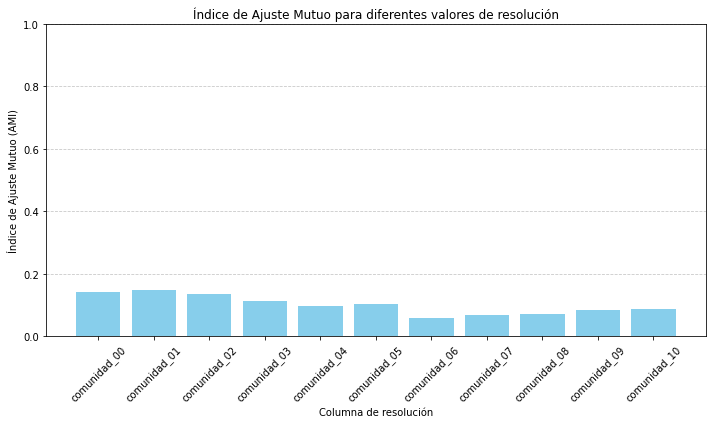

In [20]:
# Extraer las columnas de resolución y las asignaciones reales
columnas_resolucion = ['comunidad_00', 'comunidad_01', 'comunidad_02', 'comunidad_03', 'comunidad_04',
                       'comunidad_05', 'comunidad_06', 'comunidad_07', 'comunidad_08', 'comunidad_09', 'comunidad_10']
asignacion_real = df['COM']

# Calcular el Índice de Ajuste Mutuo para cada columna de resolución
ami_scores = []
for columna in columnas_resolucion:
    asignacion_predicha = df[columna]
    ami = adjusted_mutual_info_score(asignacion_real, asignacion_predicha)
    ami_scores.append(ami)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.bar(columnas_resolucion, ami_scores, color='skyblue')
plt.xlabel('Columna de resolución')
plt.ylabel('Índice de Ajuste Mutuo (AMI)')
plt.title('Índice de Ajuste Mutuo para diferentes valores de resolución Louvain')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Un valor de Adjusted Mutual Information (AMI) inferior a 0.2 indica una asociación muy débil o insignificante entre las particiones obtenidas por el algoritmo Louvain en diferentes resoluciones. El Adjusted Mutual Information mide la similitud entre dos agrupaciones, teniendo en cuenta la posibilidad de asociaciones aleatorias. Por lo tanto, un valor bajo de AMI sugiere que las agrupaciones no están relacionadas de manera significativa o que hay muy poca coincidencia entre ellas.

### Adjusted mutual info score para comunidades basadas en persona natural 

En indice AMI es adecuado cuando las entidades pueden pertenecer a múltiples grupos en las particiones que estamos comparando. Seleccionamos los datos que se cruzan entre los grupos economicos y los grupos basados en persona natural.

In [7]:
grupos_natural= spark.read.options(header=True,inferSchema=True,delimiter=",").csv("/home/cdsw/data/processed/comunidades_persona_natural/comunidades_natural_sociedades.csv")
grupos_natural.createOrReplaceTempView("grupos_natural")
grupos=spark.sql('select SOCIO_NATURAL,SOCIEDAD_RELACIONADA,  COM from grupos_natural left join grupos_conocidos on grupos_natural.SOCIEDAD_RELACIONADA=grupos_conocidos.PARU_RUT_E where COM is not null order by COM asc ').toPandas()


Ahora mapearemos los valores para asignar a cada rut de persona natural un numero. 

In [8]:
valores_unicos = grupos['SOCIO_NATURAL'].unique()

# Crea un mapeo entre los valores únicos y un rango de enteros
mapeo = {valor: idx for idx, valor in enumerate(valores_unicos)}

# Aplica el mapeo a la columna 'comunidad_str' para convertir los valores a enteros
grupos['comunidad_int'] = grupos['SOCIO_NATURAL'].map(mapeo)



Checkeamos:

In [9]:
grupos

,SOCIO_NATURAL,SOCIEDAD_RELACIONADA,COM,comunidad_int
0,5m31ZfNXseDGzn/P6O8NIw==,vbo8wuCTmtpxTD3xPYbHqA==,1,0
1,5m31ZfNXseDGzn/P6O8NIw==,5clQiGj2KqrVLAcc6XAAdg==,1,0
2,5m31ZfNXseDGzn/P6O8NIw==,5clQiGj2KqrVLAcc6XAAdg==,1,0
3,5m31ZfNXseDGzn/P6O8NIw==,sFHhxMyHBbyMX5aIXm3tow==,1,0
4,Y7vrSUKScq9sA5hMCanryQ==,sFHhxMyHBbyMX5aIXm3tow==,1,1
...,...,...,...,...
91353,B7OroJfUrRSd5qus6awLEw==,jRSQP+WM6xLpIBYx1CJh7g==,3290,9308
91354,Yc+heDAi7+HojbufVk/KcA==,9WPeQze7W5qSfoxoq6gjdA==,3290,4254
91355,lxvhrAEzbZhPi5MNm02CGw==,9WPeQze7W5qSfoxoq6gjdA==,3290,4255
91356,ELzDhgbF+la5/P8pvRowCQ==,/HuqeanaVAtzbzyJykFGng==,3291,9077


Y calculamos el indice de ajuste mutuo.

In [10]:
# Calcular el AMI entre las columnas COM y comunidad_int
ami = adjusted_mutual_info_score(grupos['COM'], grupos['comunidad_int'])

print("Índice de Ajuste Mutuo (AMI):", ami)

Índice de Ajuste Mutuo (AMI): 0.5370161917438732


Un valor de AMI de 0.5370161917438732 sugiere que hay una correspondencia moderada entre las asignaciones de agrupamiento en las dos particiones. Es decir, existe cierta consistencia o acuerdo entre las dos formas en que se han agrupado los datos, pero también hay algunas diferencias o discrepancias entre ellas.

### Cruce de valores entre comunidades de Louvain y grupos economicos

Lo que haremos ahora es analizar que grupos economicos calzan mejor en las comunidades de Louvain con diferentes resoluciones. A priori debiesemos encontrar una interseccion baja de contribuyentes por el valor AMI encontrado anteriormente. Para ello veremos el valor que mas se repite de las comunidades conocidas en cada comunidad de Louvain. Definiremos las metricas:
* Porcentaje_COM, que indica el porcentaje de la comunidad mas repetida en cada comunidad de louvan comparado con el total de los miembros de ese grupo economico correspondiente.
* Porcentaje_comunidad que indica el porcentaje de la comunidad   mas repetida en cada comunidad de Louvain comparado con el total de los miembros de esa comunidad de Louvain.

Asi, en la interseccion perfecta de las particiones, estos porcentajes debiesen ser tan cercanos a 100% cada uno como sea posible. Definimos todo en la siguiente funcion:

In [21]:
#Unimos la data de las comunidades de Louvain con los grupos economicos
data_louvain_COM=spark.sql('select cont_rut,comunidad_00,comunidad_01,comunidad_02,comunidad_03,comunidad_04,comunidad_05,comunidad_06,comunidad_07,comunidad_08,comunidad_09,comunidad_10,COM from contaminados left join grupos_conocidos on contaminados.cont_rut=grupos_conocidos.PARU_RUT_E order by COM asc').toPandas()

#Se define la funcion de analisis de columna
def analizar_columna(df, columna):
    # Agrupa por la columna y cuenta la frecuencia de cada valor de COM
    conteo_comunidad = df.groupby(columna)['COM'].value_counts().reset_index(name='conteo')

    # Encuentra el valor de COM más común en cada grupo y cuántas veces se repite
    maximos_comunidad = conteo_comunidad.groupby(columna).apply(lambda x: x.nlargest(1, 'conteo')).reset_index(drop=True)

    # Filtra los resultados para obtener solo los grupos que tienen una frecuencia mayor que cierto umbral
    umbral_frecuencia = 3  # Por ejemplo, solo consideraremos grupos con más de 5 valores repetidos de COM
    grupos_repetidos = maximos_comunidad[maximos_comunidad['conteo'] > umbral_frecuencia]

    # Agrega el tamaño de cada grupo al DataFrame
    tamanio_comunidad = df[columna].value_counts().reset_index()
    tamanio_comunidad.columns = [columna, f'tamanio_{columna}']
    grupos_repetidos_con_tamanio = pd.merge(grupos_repetidos, tamanio_comunidad, on=columna)

    # Agrega el tamaño original de cada comunidad COM
    tamanio_comunidad_COM = df['COM'].value_counts().reset_index()
    tamanio_comunidad_COM.columns = ['COM', 'tamanio_comunidad_COM']
    grupos_repetidos_con_tamanio = pd.merge(grupos_repetidos_con_tamanio, tamanio_comunidad_COM, on='COM')

    # Calcula el porcentaje entre el conteo y el tamaño de la comunidad COM
    grupos_repetidos_con_tamanio['porcentaje_COM'] = (grupos_repetidos_con_tamanio['conteo'] / grupos_repetidos_con_tamanio['tamanio_comunidad_COM']) * 100

    # Calcula el porcentaje entre el conteo y el tamaño de la comunidad
    grupos_repetidos_con_tamanio['porcentaje_comunidad'] = (grupos_repetidos_con_tamanio['conteo'] / grupos_repetidos_con_tamanio[f'tamanio_{columna}']) * 100

    # Ordena el DataFrame según el porcentaje de mayor a menor
    grupos_repetidos_ordenado = grupos_repetidos_con_tamanio.sort_values(by=['porcentaje_COM', 'porcentaje_comunidad'], ascending=[False, False])
    
    return grupos_repetidos_ordenado

# Llamar a la función para cada columna de interés
columnas = ['comunidad_00', 'comunidad_01', 'comunidad_02', 'comunidad_03', 'comunidad_04', 
            'comunidad_05', 'comunidad_06', 'comunidad_07', 'comunidad_08', 'comunidad_09', 'comunidad_10']

Aplicamos la funcion para cada columna y otenemos resultados

In [ ]:
from IPython.display import display
for columna in columnas:
    resultado = analizar_columna(data_louvain_COM, columna)
    display(resultado)
    print("\n")

In [ ]:
comunidad08=analizar_columna(data_louvain_COM, 'comunidad_08')
comunidad08.head(20)

Como vemos, los resultados de los porcentajes calculados son coherentes con el valor bajo de AMI pues hay , por lo cual la inteseccion de los grupos es bajo. 

### Cruce de valores entre comunidades ligadas a persona natural y grupos economicos

Para obtener la estadistica del valor mas repetido de la comunidad economica (moda) en ese grupo relacionado a persona natural.

In [17]:
comunidades_natural=spark.sql('select SOCIO_NATURAL,SOCIEDAD_RELACIONADA, PORCENTAJE_CAPITAL,COM as COMUNIDAD_GRUPO_REAL from grupos_natural left join grupos_conocidos on grupos_natural.SOCIEDAD_RELACIONADA=grupos_conocidos.PARU_RUT_E  order by SOCIO_NATURAL asc ')
comunidades_natural.show()
comunidades_natural=comunidades_natural.toPandas()
comunidades_natural.to_csv('/home/cdsw/data/processed/comunidades_persona_natural/comunidades_natural_cruce_grupos_economicos.csv', index=False)

+--------------------+--------------------+------------------+--------------------+
|       SOCIO_NATURAL|SOCIEDAD_RELACIONADA|PORCENTAJE_CAPITAL|COMUNIDAD_GRUPO_REAL|
+--------------------+--------------------+------------------+--------------------+
|+++Dv3VdgQyVqRTgl...|jIjACgvcsprjqLeup...|              24.0|                null|
|+++YLFFod6As3+EIq...|XdNCugfCv/JNxkjsW...|             16.67|                null|
|+++cWi/r31w33XdNY...|dqMQkYCsU9PCaLwUT...|             100.0|                null|
|+++ummH22IHC2WTkb...|IQuHAph8Cfr+adLj0...|               5.0|                null|
|++/WY9IfzTdOaYm/b...|c4z+ez0VWOAMcC03N...|             100.0|                null|
|++/qMXdh0SgFCrn7a...|hRdJVCPUyiFXCi4G4...|              50.0|                null|
|++00VLeiwaWmwnNA3...|DJKiBJC3opw4vNtY5...|              2.11|                null|
|++0NcIatEVEgy0927...|vgmWEv6Zha6WGImry...|             100.0|                null|
|++0btVP807wo5TQIL...|2flJ+DFTjTbJtNtvx...|              50.0|              

Para los siguientes calculos usamos la data que solo tiene una asignacion a grupos de persona natural y comunidad de grupo economico.

In [19]:
comunidades_not_null=spark.sql('select SOCIO_NATURAL,SOCIEDAD_RELACIONADA,  COM from grupos_natural left join grupos_conocidos on grupos_natural.SOCIEDAD_RELACIONADA=grupos_conocidos.PARU_RUT_E where COM is not null order by COM asc ').toPandas()
comunidades_not_null

,SOCIO_NATURAL,SOCIEDAD_RELACIONADA,COM
0,5m31ZfNXseDGzn/P6O8NIw==,vbo8wuCTmtpxTD3xPYbHqA==,1
1,5m31ZfNXseDGzn/P6O8NIw==,5clQiGj2KqrVLAcc6XAAdg==,1
2,5m31ZfNXseDGzn/P6O8NIw==,5clQiGj2KqrVLAcc6XAAdg==,1
3,5m31ZfNXseDGzn/P6O8NIw==,sFHhxMyHBbyMX5aIXm3tow==,1
4,Y7vrSUKScq9sA5hMCanryQ==,sFHhxMyHBbyMX5aIXm3tow==,1
...,...,...,...
91353,B7OroJfUrRSd5qus6awLEw==,jRSQP+WM6xLpIBYx1CJh7g==,3290
91354,Yc+heDAi7+HojbufVk/KcA==,9WPeQze7W5qSfoxoq6gjdA==,3290
91355,lxvhrAEzbZhPi5MNm02CGw==,9WPeQze7W5qSfoxoq6gjdA==,3290
91356,ELzDhgbF+la5/P8pvRowCQ==,/HuqeanaVAtzbzyJykFGng==,3291


Guardaremos este archivo que tiene la estadistica del cruce total de las comunidades de persona natural con los grupos conocidos.

In [22]:
resultados_natural=analizar_columna(comunidades_not_null,'SOCIO_NATURAL')
# Ordenar el DataFrame por la columna porcentaje_COM de mayor a menor
resultados_natural_ordenado = resultados_natural.sort_values(by=['porcentaje_COM', 'porcentaje_comunidad'], ascending=[False, False])
# Mostrar el DataFrame ordenado
resultados_natural_ordenado.head(20)

,SOCIO_NATURAL,COM,conteo,tamanio_SOCIO_NATURAL,tamanio_comunidad_COM,porcentaje_COM,porcentaje_comunidad
3772,342eju551ZrYm9YTPpEjUg==,1492,14,14,14,100.0,100.0
4234,4lcwFNmNXOS49UtDHBiXZA==,99,8,8,8,100.0,100.0
5308,Ekt5VmsRCBhmQUwD3wcV/g==,1151,5,5,5,100.0,100.0
5431,IVfjExIOYufNfUcXJ/9gRA==,1484,4,4,4,100.0,100.0
5474,JwCG7I9UnqAZ8mQfw/5A/Q==,1834,8,8,8,100.0,100.0
5505,KKoSOzKghO4NgcZsvX12GQ==,27,5,5,5,100.0,100.0
5634,RbLD9v9GbuHbrUyVCDV1rQ==,2434,14,14,14,100.0,100.0
5635,RbmXhYGarAKbUzwProc2dQ==,3046,7,7,7,100.0,100.0
5641,RxtSo/sp7YUBLgvFJixopw==,198,9,9,9,100.0,100.0
5790,gHFrlHghNjFy7ZkKOn4lcQ==,1251,4,4,4,100.0,100.0


Vemos que en este caso, hay una coincidencia mayor de algunas comunidades, por lo valores de porcentaje _COM y porcentaje_COMUNIDAD. 